## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import mlflow
import warnings
import pickle
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import sys, os

In [2]:
%matplotlib inline
warnings.filterwarnings("ignore")

In [3]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from file_handler import FileHandler

## Preprocessing

In [4]:
file_handler = FileHandler()
train_sales = file_handler.read_csv("../data/train.csv")

In [5]:
train = train_sales.groupby("Date").agg({"Sales": "mean"})
train

,Sales
Date,
2013-01-01,87.284560
2013-01-02,6233.030493
2013-01-03,5693.112108
2013-01-04,5954.218834
2013-01-05,5337.751570
...,...
2015-07-27,9602.952466
2015-07-28,8174.953363
2015-07-29,7623.284305


<AxesSubplot:xlabel='Date'>

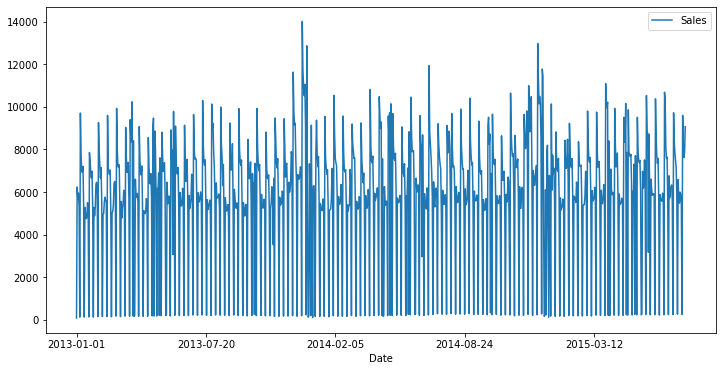

In [6]:
train.plot(figsize=(12,6))

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

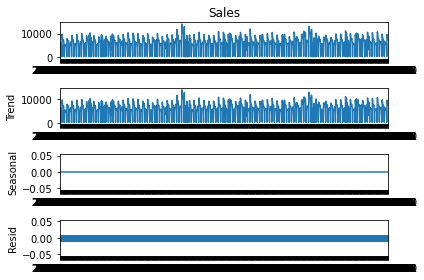

In [8]:
train.sort_index(inplace=True)
results = seasonal_decompose(train['Sales'], model='additive', extrapolate_trend='freq', period=1)
results.plot();

In [9]:
scale_train=train.copy()
std_column_df = pd.DataFrame(scale_train['Sales'])

In [10]:
std_column_values = std_column_df.values
minmax_scaler = MinMaxScaler(feature_range=(-1,1))
normalized_data = minmax_scaler.fit_transform(std_column_values)
scale_train['Sales'] = normalized_data

In [11]:
scale_train.head()

,Sales
Date,
2013-01-01,-1.000000
2013-01-02,-0.117299
2013-01-03,-0.194846
2013-01-04,-0.157344
2013-01-05,-0.245886


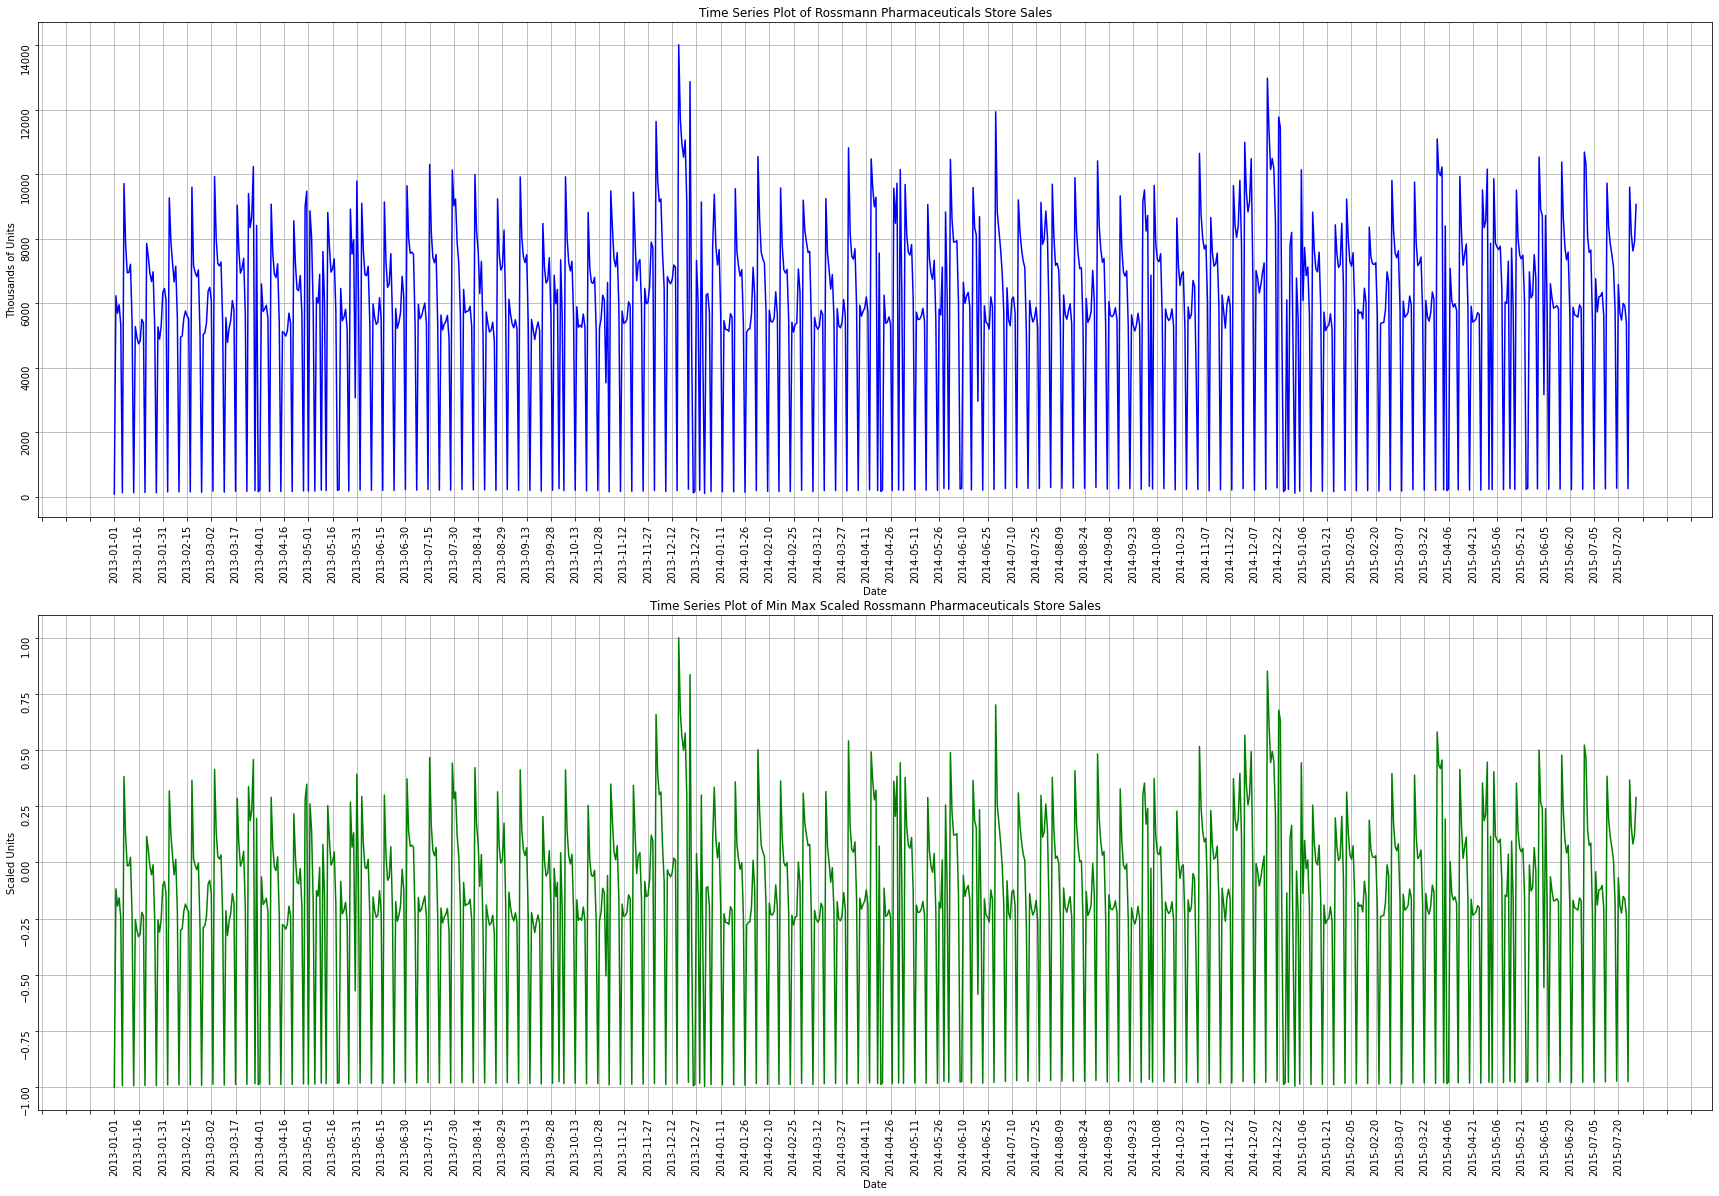

In [12]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M = 100
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(train.index, train.Sales, 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Thousands of Units')
ax1.title.set_text('Time Series Plot of Rossmann Pharmaceuticals Store Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(scale_train.index, scale_train.Sales, 'g-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Units')
ax2.title.set_text(
    'Time Series Plot of Min Max Scaled Rossmann Pharmaceuticals Store Sales')
ax2.grid(True)
plt.show()


In [13]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [14]:
sales_difference = difference(scale_train.Sales.values)

In [15]:
def corrPlots(array: np.array, prefix: str):
    plt.figure(figsize=(30, 5))
    plt.title(
        f"{prefix}  Autocorrelations of Scaled Rossmann Pharmaceuticals Store Sales Min Max Scaled")
    plt.bar(range(len(array)), array)
    plt.grid(True)
    plt.show()

In [16]:
# AutoCorrelation
acfSalesScaled = acf(scale_train.Sales.values, fft=True, nlags=45)
acfSalesScaledNp = np.array(acfSalesScaled)

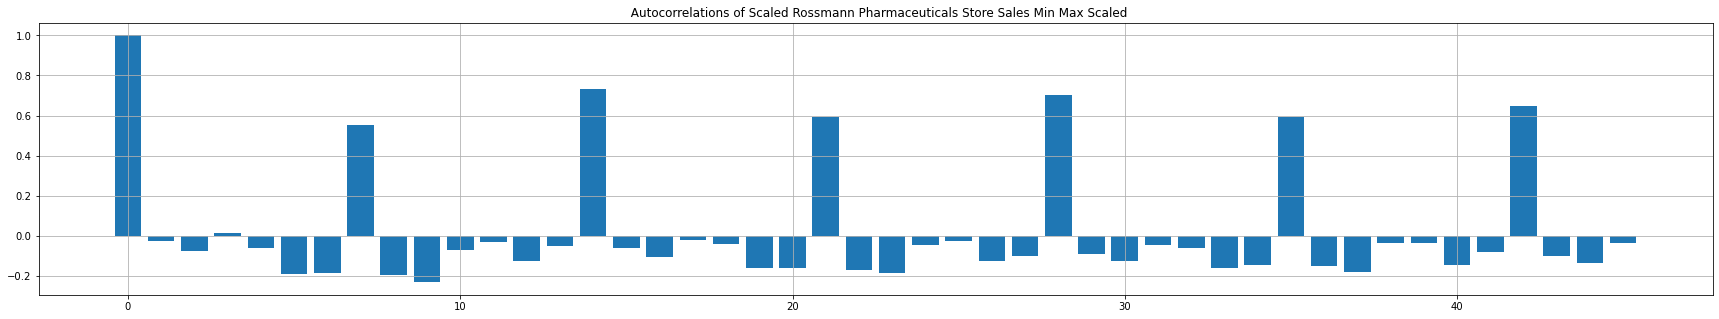

In [17]:
corrPlots(acfSalesScaledNp, '')

In [18]:
# Partial Correlation
pacfSalesScaled = pacf(scale_train.Sales.values, nlags=45)
pacfSalesScaledNp = np.array(pacfSalesScaled)

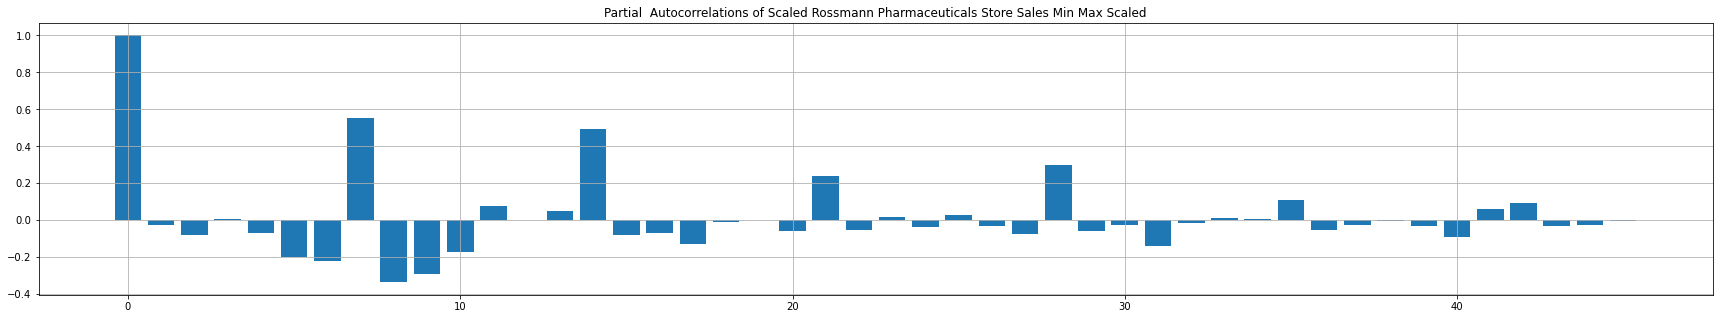

In [19]:
corrPlots(pacfSalesScaledNp, "Partial")

In [20]:
SIZE = len(scale_train.Sales)
WINDOW_SIZE = 45
BATCH_SIZE = SIZE-WINDOW_SIZE*2
EPOCHS = 200

In [21]:
# Spliting Data to Train and Test (80/20)
DateTrain = scale_train.index.values[0:BATCH_SIZE]
DateValid = scale_train.index.values[BATCH_SIZE:]
XTrain = scale_train.Sales.values[0:BATCH_SIZE].astype('float32')
XValid = scale_train.Sales.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (852, 1)
Shape of the validation set date series:  (90, 1)

Shape of the training set logarithm of sales series:  (852,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (90,)


In [22]:
tf.random.set_seed(0)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([852, 1])

In [23]:
# create tensor from each individual element
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float32, name=None)>

In [24]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True)

In [25]:
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))

In [26]:
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

In [27]:
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [28]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [29]:
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

In [30]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="mse", optimizer='adam')

In [31]:
history = model.fit(DatasetTrain, epochs=EPOCHS,
                    validation_data=DatasetVal, verbose=0)

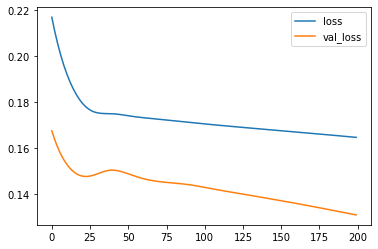

In [32]:
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [35]:
from tensorflow.keras.layers import Dropout

In [44]:
# Set window of past points for LSTM model
window = 45

# # Split 80/20 into train/test data
last = int(len(scale_train.Sales)/5.0)
Xtrain = scale_train.Sales[:-last]
Xtest = scale_train.Sales[-last-window:]

# # Store window number of points as a sequence
xin = []
next_X = []
for i in range(window, len(Xtrain)):
    try:
        xin.append(Xtrain[i-window:i])
        next_X.append(Xtrain[i])
    except Exception as e:
        print(f'i value : {i}')
        exit(0)

# Reshape data to format for LSTM
xin, next_X = np.array(xin), np.array(next_X)
xin = xin.reshape(xin.shape[0], xin.shape[1], 1)

In [41]:
# Initialize LSTM model
m = Sequential()
m.add(LSTM(units=50, return_sequences=True, input_shape=(xin.shape[1], 1)))
m.add(Dropout(0.2))
m.add(LSTM(units=50))
m.add(Dropout(0.2))
m.add(Dense(units=1))
m.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

In [42]:
# Fit LSTM model
history = m.fit(xin, next_X, epochs=200, batch_size=50, verbose=0)

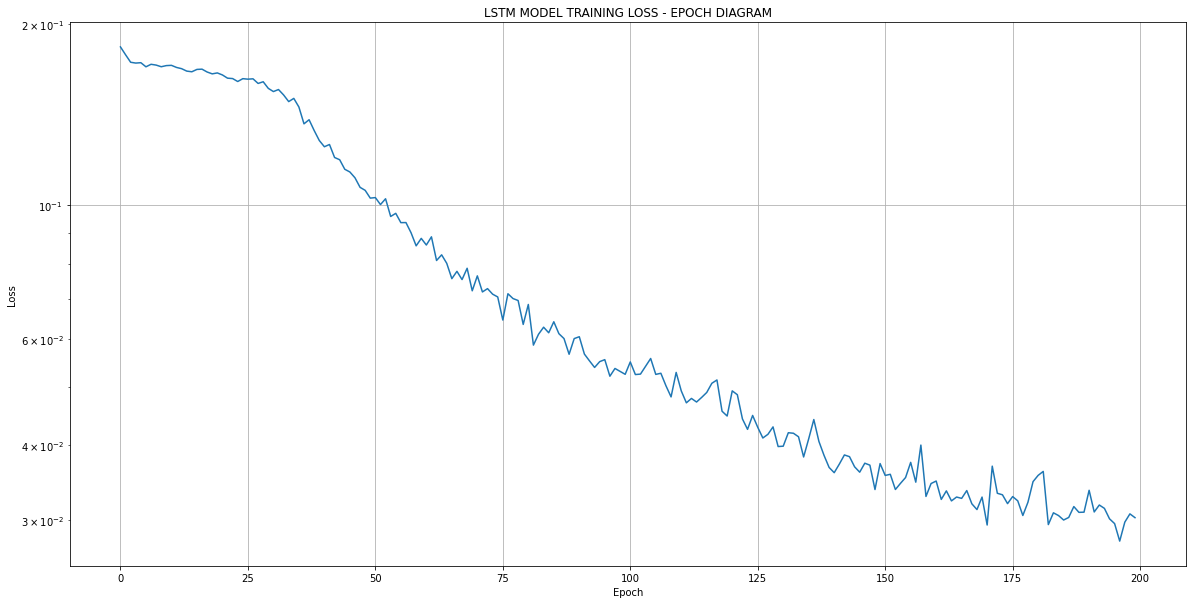

In [43]:
plt.figure(figsize=(20, 10))
plt.grid()
plt.title('LSTM MODEL TRAINING LOSS - EPOCH DIAGRAM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.semilogy(history.history['loss'])

In [45]:
# Last Loss Value
history.history['loss'][-1]

0.03029470145702362

6/6 [==============================] - 1s 17ms/step


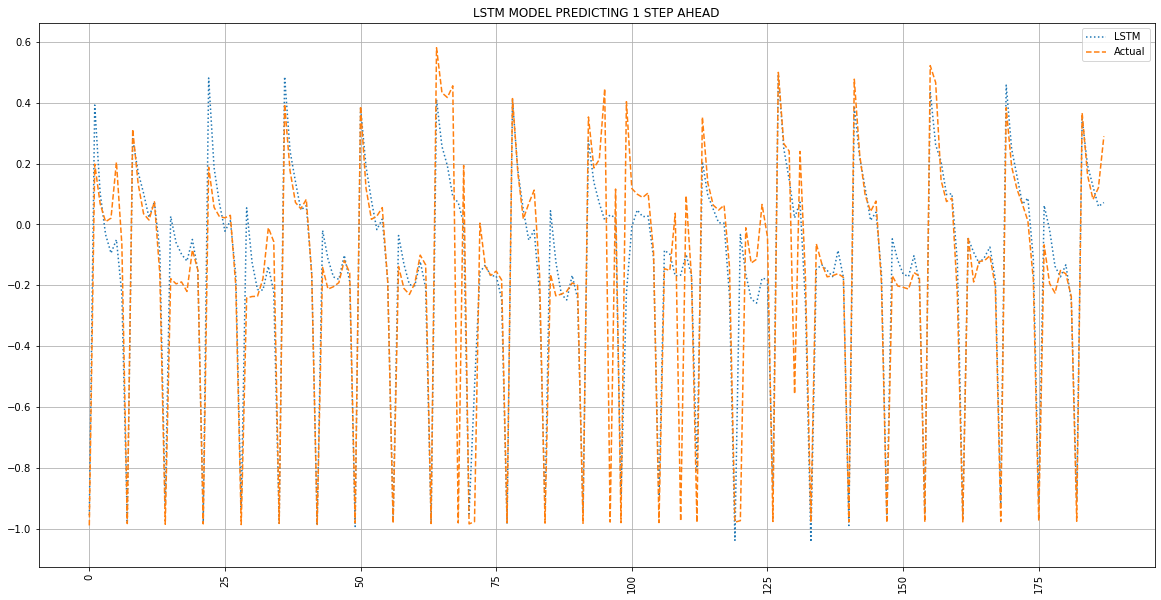

In [46]:
# Store "window" points as a sequence
xin = []
next_X1 = []
for i in range(window, len(Xtest)):
    xin.append(Xtest[i-window:i])
    next_X1.append(Xtest[i])

# Reshape data to format for LSTM
xin, next_X1 = np.array(xin), np.array(next_X1)
xin = xin.reshape((xin.shape[0], xin.shape[1], 1))

# Predict the next value (1 step ahead)
X_pred = m.predict(xin)

# Plot prediction vs actual for test data
plt.figure(figsize=(20, 10))
plt.title('LSTM MODEL PREDICTING 1 STEP AHEAD')
plt.xticks(rotation=90)
plt.grid()
plt.plot(X_pred, ':', label='LSTM')
plt.plot(next_X1, '--', label='Actual')
plt.legend()

1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 28ms/step


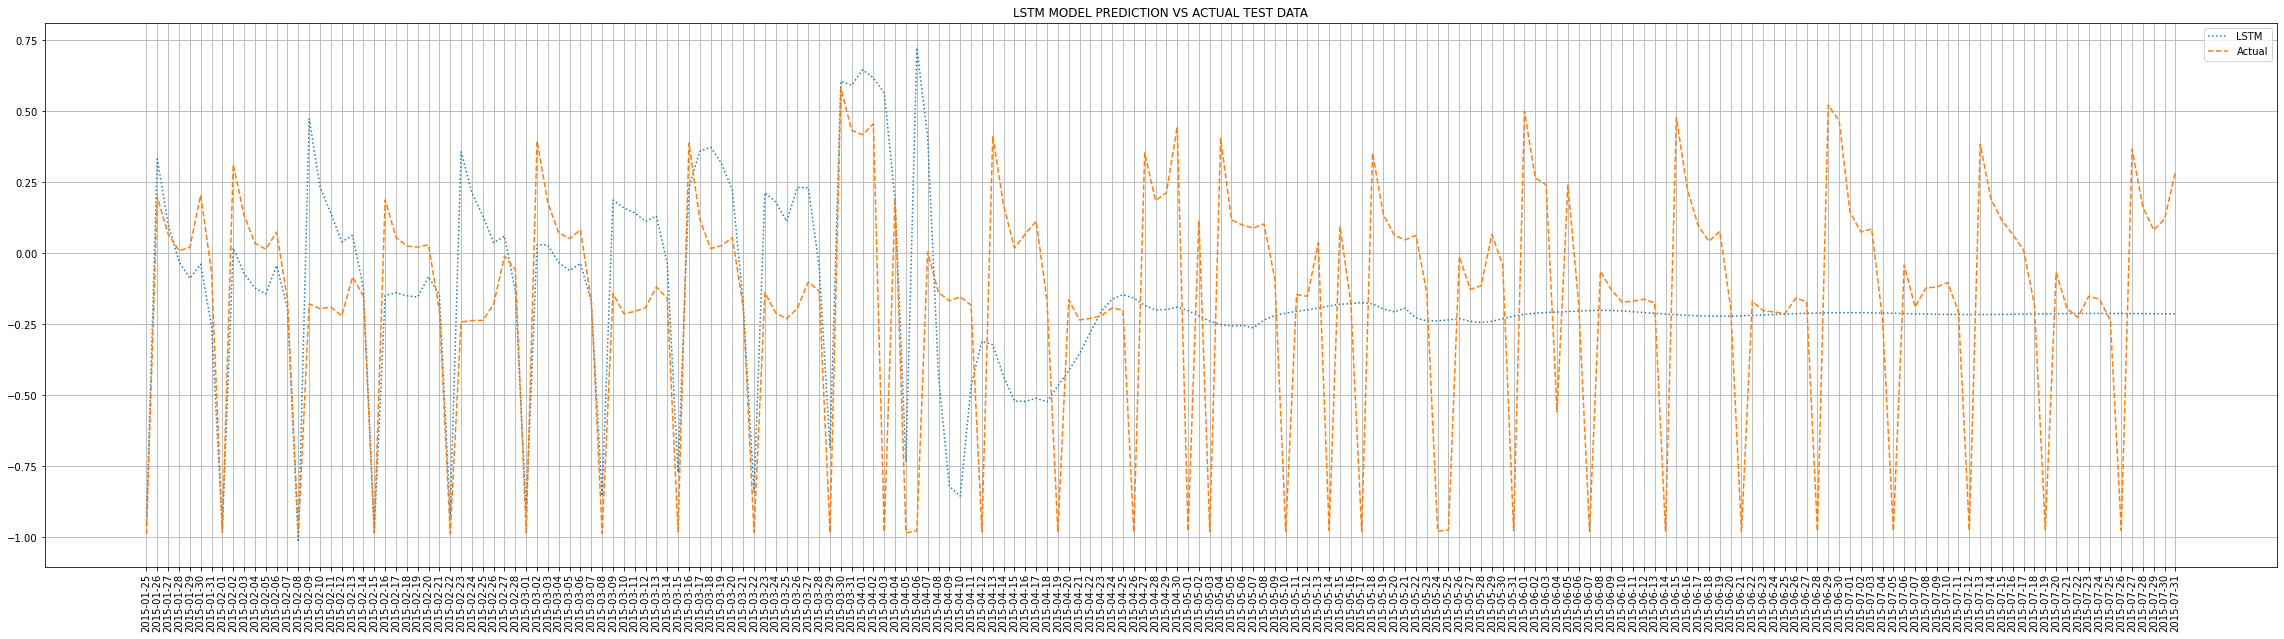

In [49]:
# Using predicted values to predict next step
X_pred = Xtest.copy()
for i in range(window, len(X_pred)):
    xin = X_pred[i-window:i].to_numpy().reshape((1, window, 1))
    X_pred[i] = m.predict(xin)

# Plot prediction vs actual for test data
plt.figure(figsize=(40,10))
plt.title('LSTM MODEL PREDICTION VS ACTUAL TEST DATA')
plt.xticks(rotation=90)
plt.grid()
plt.plot(X_pred[window:], ':', label='LSTM')
plt.plot(next_X1, '--', label='Actual')
plt.legend()

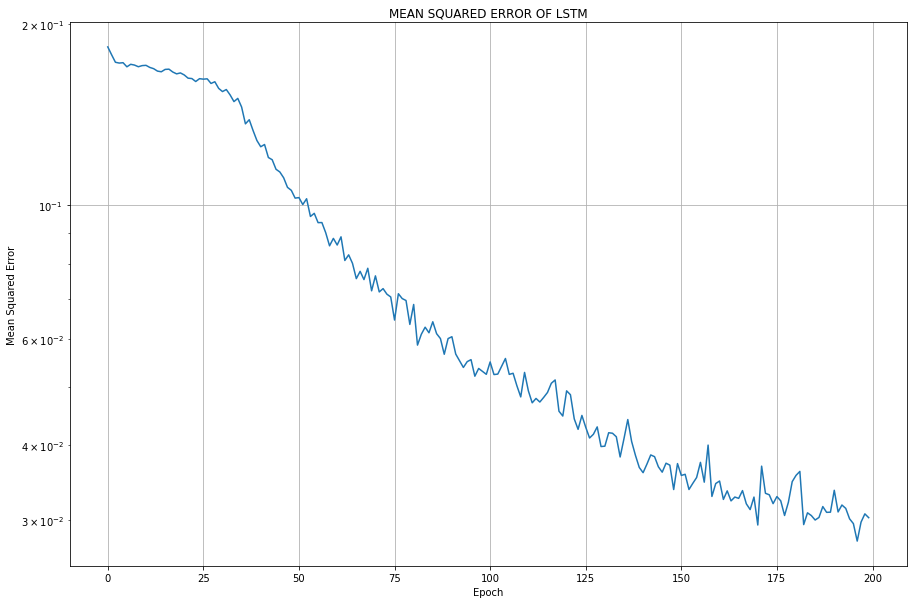

In [50]:
plt.figure(figsize=(15, 10))
plt.grid()
plt.title('MEAN SQUARED ERROR OF LSTM')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.semilogy(history.history['mse'])

In [51]:
# Last MSE Value
history.history['mse'][-1]

0.03029470145702362

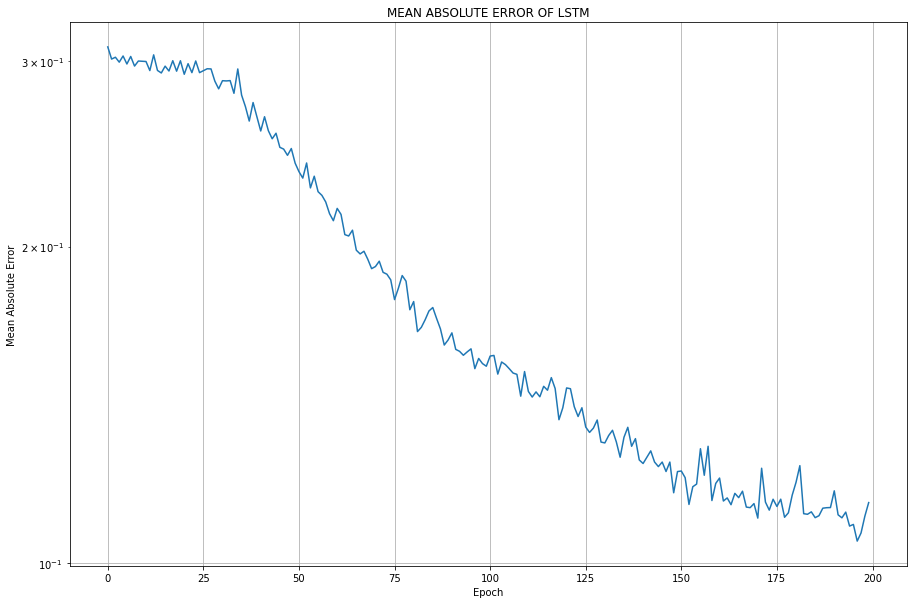

In [52]:
plt.figure(figsize=(15, 10))
plt.grid()
plt.title('MEAN ABSOLUTE ERROR OF LSTM')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.semilogy(history.history['mae'])

In [53]:
# Last MAE Value
history.history['mae'][-1]

0.11412397772073746